# Image Classification with German Traffic Signs


<a class="anchor" id="chapter1"></a>

<font size=4>
    
* [Necessary Libraries](#chapter0)
    
* [Introduction](#chapter1)  
        
* [Data](#chapter2)
  
* [Data Preparation](#chapter3)

    * [Uploading Data](#section2)
    
    * [Splitting, One-hot Encoding and Scaling](#section3)
    
* [Models](#chapter4)
    
    * [CNN Model 1](#section5)    
    * [CNN-RF Model 1](#section6)
    * [CNN Model 2](#section7)
    * [CNN-RF Model 2](#section8)
    * [CNN Model 3](#section9)
    * [CNN-RF Model 3](#section10)  
    
* [Model Comparison](#chapter5)    
* [Best Model](#chapter6)
* [Conclusion](#chapter7)
* [References](#chapter8)

<font>


# Necessary Libraries <a class="anchor" id="chapter0"></a>

In [19]:
import warnings
warnings.filterwarnings('ignore')x"

In [20]:
import pandas as pd
import numpy as np

import os
import cv2
import glob
import pickle

import tensorflow as tf

import keras
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model, load_model
from keras.layers  import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from PIL import Image
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt

from IPython.display import display, Image

%matplotlib inline

# Introduction<a class="anchor" id="chapter1"></a>

<font size=4 > 
    
The goal of this study is to build and maintain a deep learning model that can discriminate traffic signs with high accuracy. For this aim, 3  different CNN architectures are built and  3 of these CNN models are combined with a random forest algorithm. All algorithms are optimized and this grid search method is used for the random forest. Moreover, by taking into consideration the test accuracies, over-fitting, and computational efficiency, the best model is selected for the image classification. Therefore, the last testing and the application of the model is done by feed the model with a random image and observe the output of the model.

<font>

# Data <a class="anchor" id="chapter2"></a>

<font size=4 >

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011.
    
The data resource is Kaggle : [GTSRB - German Traffic Sign Recognition Benchmark ](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Train)

* Single-image, multi-class classification problem.

* There are 43 classes.

* More than 50,000 images in total.

* Large, lifelike database.

For each class, there are different photos with different light and different angle. Therefore, the recognition will be wider for each traffic sign. The example is shown below for several different traffic signs from meta data:

    
<font>

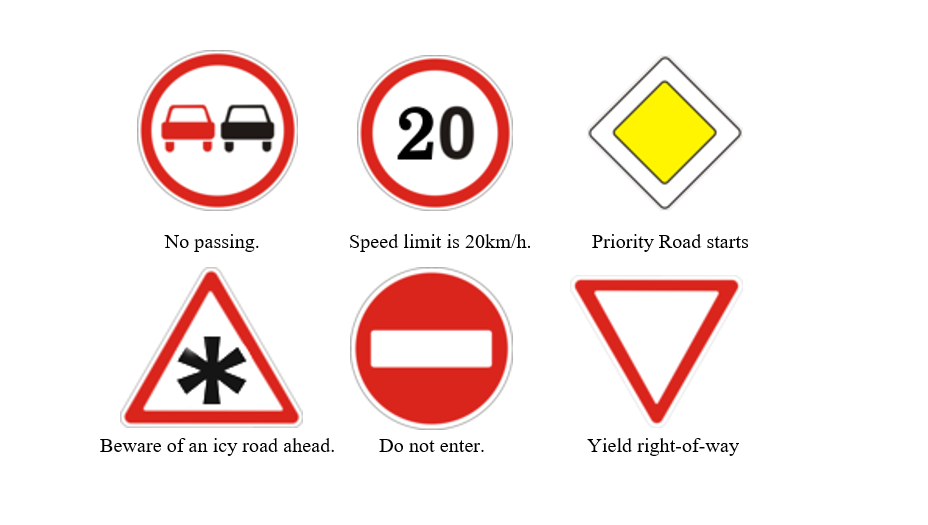

In [21]:
display(Image(filename="Images/SignExamples.png"))

In [8]:
# directory = os.chdir("...")

# Data Preparation <a class="anchor" id="chapter3"></a>

## Uploading Data <a class="anchor" id="section2"></a>

In [12]:
ImageDf = []
Labels = []
image_dir = glob.glob('Train/**/**')

for index, image in enumerate(image_dir):
    images = Image.open(image)
    images = images.resize((30,30)) 
    images = np.array(images)
    ImageDf.append(images)

    if image_dir[index][7] == '\\':
        new_number = int(image_dir[index][6])
        Labels.append(new_number)
    else:
        new_number = int(image_dir[index][6:8])
        Labels.append(new_number)
    
ImageDf = np.array(ImageDf)
Labels = np.array(Labels)

## Splitting, One-hot Encoding and Scaling  <a class="anchor" id="section3"></a>

<font size=4 >  In this part, data is split by using train_test_split method from sklearn package. Splitting is done with the  0.7 sizes of the train, 0.15 sizes of the test, and 0.15 size of the validation dataset. Furthermore, to improving classification performance, one-hot encoding is applied for all train, test, and validation target variables. After scaling processes, the class names are assigned for further processes. </font>

In [13]:
x_train, x_test, y_train, y_test = train_test_split(ImageDf, Labels, test_size=0.3, random_state=42, shuffle= True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42, shuffle= True)

In [14]:
# Extraction lables before one-hot encoding
label_train = y_train
label_test = y_test
label_val = y_val

# Labels are turned pandas data frame for random forest model
LabelsRF = pd.DataFrame(Labels)

# One-hot encoding
y_train = to_categorical(label_train, 43)
y_test = to_categorical(label_test, 43)
y_val = to_categorical(label_val, 43) 

In [15]:
print('X train set shape: {}'.format(x_train.shape))
print('Y train set shape: {}'.format(y_train.shape))
print('X test set shape: {}'.format(x_test.shape))
print('Y test set shape: {}'.format(y_test.shape))
print('X validation set shape: {}'.format(x_val.shape))
print('Y validation set shape: {}'.format(y_val.shape))

X train set shape: (27446, 30, 30, 3)
Y train set shape: (27446, 43)
X test set shape: (5881, 30, 30, 3)
Y test set shape: (5881, 43)
X validation set shape: (5882, 30, 30, 3)
Y validation set shape: (5882, 43)


In [16]:
scaled_train = np.array(x_train / 255.0)
scaled_val = np.array(x_val / 255.0)
scaled_test =  np.array(x_test / 255.0)

In [17]:
classes = [ 'Speed limit is 20km/h.',
            'Speed limit is 30km/h.', 
            'Speed limit is 50km/h.', 
            'Speed limit is 60km/h.', 
            'Speed limit is 70km/h.', 
            'Speed limit is 80km/h.', 
            'End of speed 80km/h speed limit.', 
            'Speed limit is 100km/h.', 
            'Speed limit is 120km/h.', 
            'No passing.', 
            'No passing for vehicles with a total weight of over 3.5 tons.', 
            'Crossroad ahead, side roads to right and left.', 
            'Priority Road starts.', 
            'Yield right-of-way.', 
            'Stop', 
            'No entry for any kind of Vehicle. ', 
            'No entry for motor vehicles more than 3,5 tons.', 
            'Do not enter.', 
            'General danger / warning sign.', 
            'A single curve is approaching in left direction.', 
            'A single curve is approaching in right direction.', 
            'Indicates an approaching double curve - first left.', 
            'Indicates rough road ahead.', 
            'Danger of skidding or slipping.', 
            'Road narrows from the right side.', 
            'Work in process. Be aware of workers.', 
            'Indicates traffic light ahead.', 
            'Pedestrian crossing ahead.', 
            'Warning for children and minors.', 
            'Be aware of cyclists.', 
            'Beware of an icy road ahead. The road can be slippery.',
            'Indicates wild animals may cross the road.', 
            'End of all previously set passing and speed restrictions.', 
            'Indicates that traffic must turn right.', 
            'Mandatory direction of travel is left.', 
            'Ahead Only.', 
            'Driving straight ahead or turning right mandatory.', 
            'Driving straight ahead or turning left mandatory.', 
            'Pass on right only.', 
            'Passing left compulsory.', 
            'Direction of traffic on roundabout', 
            'End of no passing zone for vehicles under 3.5 tons.', 
            'End of all passing (overtaking) restrictions.' ]

# Models <a class="anchor" id="chapter4"></a>

<font size=4 >

#### CNN Models
    
In this section, 3 different CNN models are employed. Each CNN model has tested the prediction power by using a test dataset. Each of the CNN models includes at least one convolutional layer, pooling layer, fully connected input layer (flatten), first fully connected layer, and a fully connected output layer with 43 units which is equal to the class number. Two different activation functions are used namely relu and softmax for all CNN models. Relu is used for convolutional layers and the first fully connected layer. Furthermore, softmax is used for a fully connected output layer for all models.
Also, ADAM is used as an optimizer and categorical cross-entropy is used as a loss function. Lastly, the metrics are determined for accuracy for all models in this study.
    
###### ReLu function
$$ f(x)= \left \{ \begin{align} 0 \: \: \: \: for \: x<0 \\ x \: \: \: \: for \: x\geq0 \end{align}  \right \}$$
    


<font>

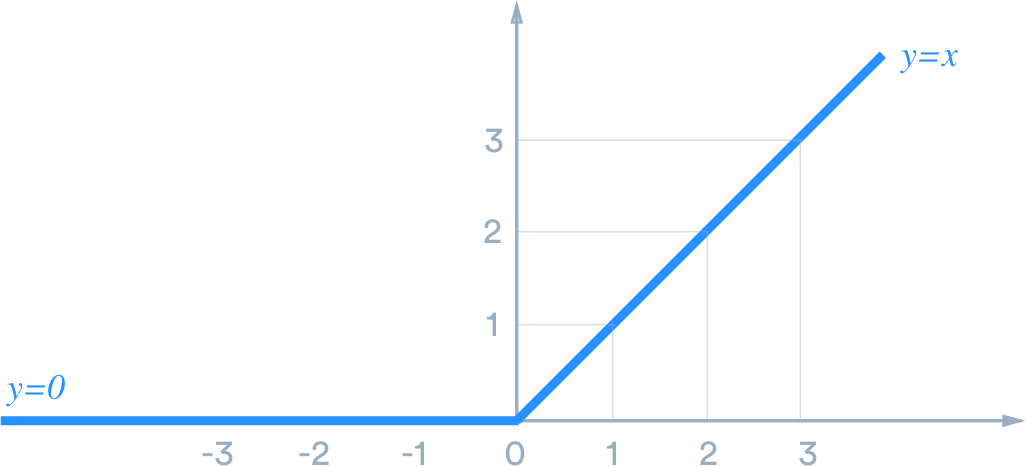

In [22]:
display(Image(filename="Images/reLunew.png"))

<font size=4 >
    
###### Softmax function
    

$$ \sigma	=	softmax$$

$$ \vec{z}	=	input vector$$

$$ e^{z_{i}}	=	standard exponential function for input vector$$

$$ K	=	number of classes in the multi-class classifier$$

$$ e^{z_{j}}	=	standard exponential function for output vector$$

$$ e^{z_{j}}	=	standard exponential function for output vector$$
    

<font>

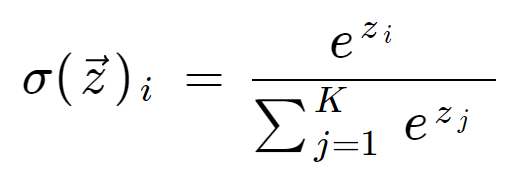

In [23]:
display(Image(filename="Images/softmax.png"))

<font size=4 >

The first step is from the CNN model extracting important features that are determined by the model. To achieve this, the Model method from Keras is used for this goal and the important features are extracted from the first fully connected layer. Moreover, a data frame is generated from the extracted features, and with the help of the train_test_split method, the data is prepared for a random forest algorithm. Furthermore, 5 k-fold is assigned for all random forest models. To optimize results better, a grid search is done. Each grid search is initiated as it follows:

 * n_estimators:30, 40, 50
    
    
 * min_samples_leaf:2, 10, 30
    
    
 * max_depth: 50, 60, 70, 80
    
Then depending on the model output, the grid search parameters rearranged and the training process is started again. This process happens until the find the optimal hyperparameters under these conditions.
    
<font>

## CNN Model 1  <a class="anchor" id="section5"></a>

<font size=4 >This model highly similar to the model which is described above. This mode is initiated with 20 epochs  </font>

In [23]:
model2 = load_model('models/model1Conv25020ep.h5')

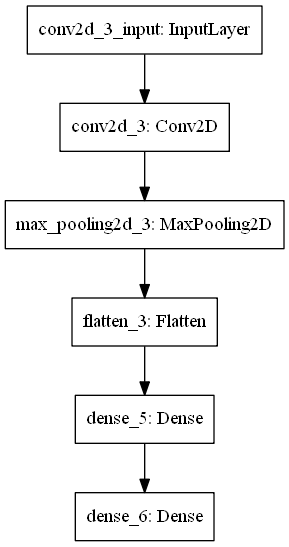

In [39]:
plot_model(model2, to_file='model.png')

In [20]:
# Initialize the model object
model2 = Sequential()

# Convolutional Layer
model2.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', input_shape = x_train.shape[1:]))
model2.add(MaxPooling2D(pool_size=(2,2)))

# Flattening layer and dense layer 
model2.add(Flatten())

model2.add(Dense(250, activation='relu'))

model2.add(Dense(43, activation='softmax')) 


model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1568250   
_________________________________________________________________
dense_2 (Dense)              (None, 43)                10793     
Total params: 1,579,939
Trainable params: 1,579,939
Non-trainable params: 0
_________________________________________________________________


In [63]:
epochs = 20
batch_size = 64

history = model2.fit(scaled_train, y_train, batch_size = batch_size,
                    epochs=epochs,  validation_data=(scaled_val, y_val))

Train on 27446 samples, validate on 5882 samples
Epoch 1/20
27446/27446 [==============================] - 17s 621us/step - loss: 1.4010 - accuracy: 0.6408 - val_loss: 0.5181 - val_accuracy: 0.8589
Epoch 2/20
27446/27446 [==============================] - 17s 613us/step - loss: 0.3188 - accuracy: 0.9258 - val_loss: 0.2650 - val_accuracy: 0.9249
Epoch 3/20
27446/27446 [==============================] - 17s 604us/step - loss: 0.1617 - accuracy: 0.9628 - val_loss: 0.1602 - val_accuracy: 0.9623
Epoch 4/20
27446/27446 [==============================] - 16s 594us/step - loss: 0.1021 - accuracy: 0.9771 - val_loss: 0.1377 - val_accuracy: 0.9667
Epoch 5/20
27446/27446 [==============================] - 17s 621us/step - loss: 0.0778 - accuracy: 0.9815 - val_loss: 0.1271 - val_accuracy: 0.9714
Epoch 6/20
27446/27446 [==============================] - 17s 620us/step - loss: 0.0524 - accuracy: 0.9879 - val_loss: 0.1078 - val_accuracy: 0.9784
Epoch 7/20
27446/27446 [==============================] -

In [24]:
scores1 = model2.evaluate(scaled_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores1[1], 100-scores1[1]*100))

Accuracy: 0.9838463068008423 
 Error: 1.6153693199157715


In [131]:
# model2.save("model1Conv25020ep.h5") #  Accuracy: 0.9838463068008423 

In [260]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               1568250   
_________________________________________________________________
dense_6 (Dense)              (None, 43)                10793     
Total params: 1,579,939
Trainable params: 1,579,939
Non-trainable params: 0
_________________________________________________________________


In [26]:
pred = model2.predict_classes(scaled_test)
report = classification_report(label_test, pred, target_names=classes)
print(report) 

                                                               precision    recall  f1-score   support

                                       Speed limit is 20km/h.       1.00      1.00      1.00        19
                                       Speed limit is 30km/h.       0.98      0.99      0.98       340
                                       Speed limit is 50km/h.       0.97      0.98      0.98       305
                                       Speed limit is 60km/h.       0.96      0.98      0.97       238
                                       Speed limit is 70km/h.       1.00      0.99      0.99       308
                                       Speed limit is 80km/h.       0.95      0.97      0.96       277
                             End of speed 80km/h speed limit.       0.97      0.98      0.98        64
                                      Speed limit is 100km/h.       1.00      0.98      0.99       219
                                      Speed limit is 120km/h.       1.00

## CNN-RF Model 1  <a class="anchor" id="section6"></a>

<font size=4 >Now the rf algorithm is combined with the previous CNN model. The first thing is extracting the important features from the first fully connected dense layer namely dense_5 for this example. Then, a data frame is crated from the extracted features for the pre-processing for the random forest. Furthermore, the data is split by 0.2 probably of test and the data is also shuffled. Moreover, the number of kfold and grid search parameters are determined. The same number of kfold is used for all cross-validation operations. After parameters are optimized, the last model is built among the options. This process is the same for all CNN-RF models during this project.</font>

In [30]:
layer_name = 'dense_5'
CNN_model2 = Model(inputs=model2.input,
                                 outputs=model2.get_layer(layer_name).output)

In [31]:
FeaturesModel2 = []
for images in ImageDf:
    images = np.expand_dims(images, axis = 0)
    image_outputs = CNN_model2.predict(images)
    FeaturesModel2.append(image_outputs)

In [32]:
features_df = pd.DataFrame(FeaturesModel2[0])
for i in FeaturesModel2:
    if i is not FeaturesModel2[0]:
       features_df =  features_df.append(pd.DataFrame(i))

In [33]:
x_trainRF, x_testRF, y_trainRF, y_testRF = train_test_split(features_df, LabelsRF, test_size=0.2, random_state=42, shuffle= True)

In [118]:
kfold = KFold(n_splits=5, random_state=42)

params_rf = {
    'n_estimators':[30, 40, 50], 'min_samples_leaf':[2, 10, 30], 'max_depth': [50, 60, 70, 80]
}

In [119]:
rf = RandomForestClassifier(random_state = 42)

grid_search_rf = GridSearchCV(rf, param_grid = params_rf, cv = kfold, scoring = 'accuracy')
grid_search_rf.fit(x_trainRF, y_trainRF) 


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [20], 'min_samples_leaf': [2],
                         'n_estimators': [280, 290, 300, 320]},
             scoring='accuracy')

In [34]:
# The best model from all rf models for CNN model 1
best_model_rf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=280,
                       random_state=42)
best_model_rf.fit(x_trainRF, y_trainRF)

# For each grid search, each best model is extracted as follows:
# best_model_rf = grid_search_rf.best_estimator_


best_model_rf

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=280,
                       random_state=42)

In [35]:
y_pred_rf = best_model_rf.predict(x_testRF) 
accuracyRF = accuracy_score(y_testRF, y_pred_rf)
accuracyRF

0.9855904106095383

In [36]:
report = classification_report(y_testRF, y_pred_rf, target_names=classes)
print(report)    

                                                               precision    recall  f1-score   support

                                       Speed limit is 20km/h.       1.00      0.79      0.88        38
                                       Speed limit is 30km/h.       0.98      0.99      0.98       496
                                       Speed limit is 50km/h.       0.99      0.99      0.99       420
                                       Speed limit is 60km/h.       0.98      0.99      0.98       294
                                       Speed limit is 70km/h.       0.99      0.99      0.99       400
                                       Speed limit is 80km/h.       0.97      0.97      0.97       364
                             End of speed 80km/h speed limit.       1.00      0.97      0.99        69
                                      Speed limit is 100km/h.       1.00      0.97      0.99       313
                                      Speed limit is 120km/h.       0.99

In [ ]:
filename = "/Models/CNNRF1.sav"
pickle.dump(best_model_rf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(x_trainRF, y_trainRF)
predloaded = loaded_model.predict(x_testRF) 
accuracyRFloaded = accuracy_score(y_testRF, predloaded)
accuracyRFloaded

## CNN Model 2 <a class="anchor" id="section7"></a>

<font size=4 >This time more complex CNN model is used.  It is contained 3 single convolutional layers and 3 single max-pooling layers. In addition to these, to prevent overfitting and increase the performance dropout method is used with 0.5 probability. The architecture as follows:</font>

In [38]:
model4 = load_model('models/model3Conv250.h5')

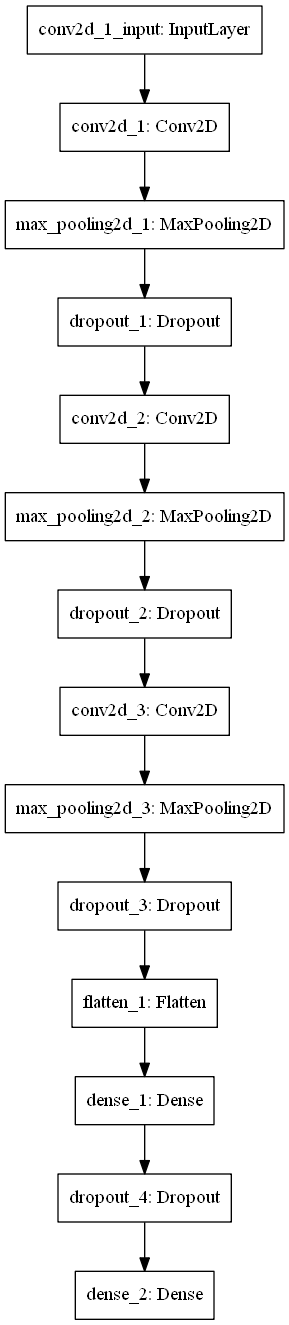

In [40]:
plot_model(model4, to_file='model2.png')

In [275]:
model4 = Sequential()

model4.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', input_shape = x_train.shape[1:]))


model4.add(MaxPooling2D(pool_size=(2,2), padding = "same"))

model4.add(Dropout(rate=0.5))

model4.add(Conv2D(filters = 64, kernel_size=(5,5), activation = 'relu'))

model4.add(MaxPooling2D(pool_size=(2,2), padding = "same"))

model4.add(Dropout(rate = 0.5))

model4.add(Conv2D(filters = 128, kernel_size=(5,5), activation = 'relu'))

model4.add(MaxPooling2D(pool_size=(2,2), padding = "same"))

model4.add(Dropout(rate = 0.5))

model4.add(Flatten())

model4.add(Dense(128, activation='relu'))

model4.add(Dropout(rate = 0.5))

model4.add(Dense(43, activation='softmax'))  

          
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [160]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)        

In [51]:
max_epochs = 50
batch_size = 64

# early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history= model4.fit(scaled_train, y_train, batch_size = batch_size,
#                    callbacks = [early_stopping],
                   epochs = max_epochs,
                   validation_data = (scaled_val, y_val))

Train on 27446 samples, validate on 5882 samples
Epoch 1/50
27446/27446 [==============================] - 20s 743us/step - loss: 2.6826 - accuracy: 0.2383 - val_loss: 1.4145 - val_accuracy: 0.5680
Epoch 2/50
27446/27446 [==============================] - 20s 719us/step - loss: 1.3205 - accuracy: 0.5607 - val_loss: 0.6129 - val_accuracy: 0.8206
Epoch 3/50
27446/27446 [==============================] - 20s 723us/step - loss: 0.8765 - accuracy: 0.7111 - val_loss: 0.3646 - val_accuracy: 0.9150
Epoch 4/50
27446/27446 [==============================] - 20s 720us/step - loss: 0.6823 - accuracy: 0.7741 - val_loss: 0.2472 - val_accuracy: 0.9413
Epoch 5/50
27446/27446 [==============================] - 22s 790us/step - loss: 0.5817 - accuracy: 0.8090 - val_loss: 0.1922 - val_accuracy: 0.9553
Epoch 6/50
27446/27446 [==============================] - 23s 856us/step - loss: 0.5108 - accuracy: 0.8312 - val_loss: 0.1488 - val_accuracy: 0.9648
Epoch 7/50
27446/27446 [==============================] -

In [162]:
scores = model4.evaluate(scaled_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Accuracy: 0.9945587515830994 
 Error: 0.5441248416900635


In [17]:
 #model4.save("model3Conv250.h5")

In [161]:
pred = model4.predict_classes(scaled_test)
report = classification_report(label_test, pred, target_names=classes)
print(report)

                                                               precision    recall  f1-score   support

                                       Speed limit is 20km/h.       1.00      0.95      0.97        19
                                       Speed limit is 30km/h.       1.00      0.99      1.00       340
                                       Speed limit is 50km/h.       1.00      0.99      0.99       305
                                       Speed limit is 60km/h.       1.00      0.97      0.98       238
                                       Speed limit is 70km/h.       1.00      1.00      1.00       308
                                       Speed limit is 80km/h.       0.96      1.00      0.98       277
                             End of speed 80km/h speed limit.       0.98      0.97      0.98        64
                                      Speed limit is 100km/h.       0.99      1.00      0.99       219
                                      Speed limit is 120km/h.       1.00

## CNN-RF Model 2<a class="anchor" id="section8"></a>

<font size=4 >All the steps are the same as the previous  CNN-RF model.</font>

In [163]:
layer_name = 'dense_1'
CNN_model4 = Model(inputs=model4.input,
                                 outputs=model4.get_layer(layer_name).output)

In [164]:
FeaturesModel4 = []
for images in ImageDf:
    images = np.expand_dims(images, axis = 0)
    image_outputs = CNN_model4.predict(images)
    FeaturesModel4.append(image_outputs)

In [165]:
FeaturesModel4_df = pd.DataFrame(FeaturesModel4[0])
for i in FeaturesModel4:
    if i is not FeaturesModel4[0]:
       FeaturesModel4_df =  FeaturesModel4_df.append(pd.DataFrame(i))

In [168]:
x_trainRF2, x_testRF2, y_trainRF2, y_testRF2 = train_test_split(FeaturesModel4_df, LabelsRF,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                shuffle= True)

In [78]:
kfold = KFold(n_splits=5, random_state=42)

params_rf2 = {
    'n_estimators':[90], 'min_samples_leaf':[2], 'max_depth': [50, 60, 70, 80] }  


In [79]:
rf2 = RandomForestClassifier(random_state=42)

grid_search_rf2 = GridSearchCV(rf2, param_grid=params_rf2, cv=kfold, scoring='accuracy')

grid_search_rf2.fit(x_trainRF2, y_trainRF2) 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [50, 60, 70, 80], 'min_samples_leaf': [2],
                         'n_estimators': [90]},
             scoring='accuracy')

In [169]:
# For retrain, the best version of the model is used.
best_model_rf2 = RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=70,
                       random_state=42)

best_model_rf2.fit(x_trainRF2, y_trainRF2)



# best_model_rf2 = grid_search_rf2.best_estimator_


best_model_rf2

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=70,
                       random_state=42)

In [226]:
y_pred_rf2 = best_model_rf2.predict(x_testRF2) 
accuracyRF2 = accuracy_score(y_testRF2, y_pred_rf2)
accuracyRF2

0.9909461871971436

In [171]:
report = classification_report(y_testRF2, y_pred_rf2, target_names=classes)
print(report)  

                                                               precision    recall  f1-score   support

                                       Speed limit is 20km/h.       1.00      0.89      0.94        38
                                       Speed limit is 30km/h.       0.99      0.99      0.99       496
                                       Speed limit is 50km/h.       0.98      0.98      0.98       420
                                       Speed limit is 60km/h.       0.99      0.99      0.99       294
                                       Speed limit is 70km/h.       0.99      0.99      0.99       400
                                       Speed limit is 80km/h.       0.96      0.98      0.97       364
                             End of speed 80km/h speed limit.       0.99      0.99      0.99        69
                                      Speed limit is 100km/h.       1.00      0.99      1.00       313
                                      Speed limit is 120km/h.       0.99

In [271]:
filename = '/CNNRF2.sav'
pickle.dump(best_model_rf2, open(filename, 'wb'))

In [187]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(x_trainRF2, y_trainRF2)
predloaded = loaded_model.predict(x_testRF2) 
accuracyRF2loaded = accuracy_score(y_testRF2, predloaded)
accuracyRF2loaded

## CNN Model 3 <a class="anchor" id="section9"></a>

<font size=4 > This is the most complex CNN architecture of this study. Double convolutional layers and max pool layers are used.  As it is done the previous model dropout method is used by 0.5 probably.  This time padding parameter is determined as "same" to yield an output without losing size for the layers. The architecture as follows:</font>

In [41]:
model3 = load_model('models/model6Conv250.h5')

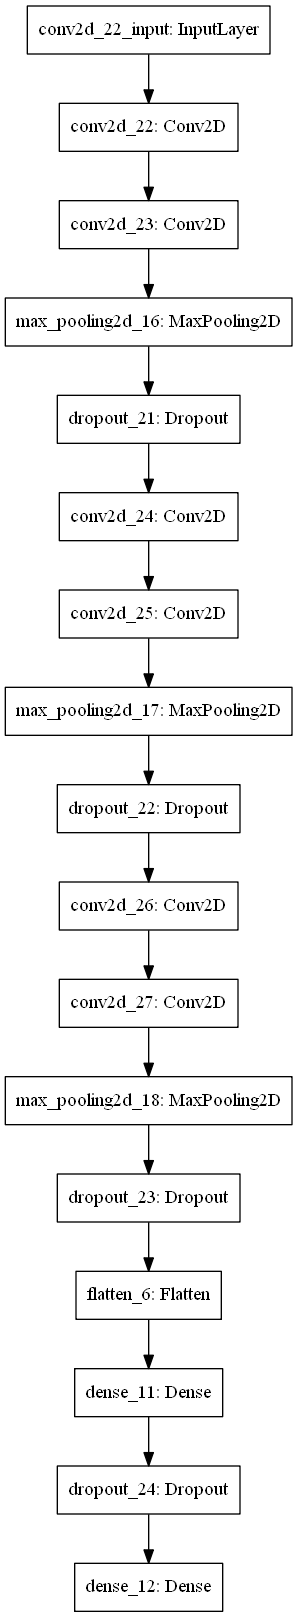

In [42]:
plot_model(model3, to_file='model3.png')

In [88]:
model3 = Sequential()

model3.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', padding = "same", input_shape = x_train.shape[1:]))
model3.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', padding = "same"))

model3.add(MaxPooling2D(pool_size=(2,2), padding = "same"))

model3.add(Dropout(rate=0.5))

model3.add(Conv2D(filters = 64, kernel_size=(5,5), activation = 'relu', padding = "same"))
model3.add(Conv2D(filters = 64, kernel_size=(5,5), activation = 'relu', ))

model3.add(MaxPooling2D(pool_size=(2,2), padding = "same"))

model3.add(Dropout(rate = 0.5))

model3.add(Conv2D(filters = 128, kernel_size=(5,5), activation = 'relu', padding = "same"))
model3.add(Conv2D(filters = 128, kernel_size=(5,5), activation = 'relu'))

model3.add(MaxPooling2D(pool_size=(2,2), padding = "same"))

model3.add(Dropout(rate = 0.5))

model3.add(Flatten())

model3.add(Dense(250, activation='relu'))

model3.add(Dropout(rate = 0.5))

model3.add(Dense(43, activation='softmax'))  

          
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [96]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 64)        51264     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 64)        102464    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 64)         

In [89]:
max_epochs = 50
batch_size = 64

# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history= model3.fit(scaled_train, y_train, batch_size = batch_size,
#                    callbacks = [early_stopping],
                   epochs = max_epochs,
                   validation_data = (scaled_val, y_val))

Train on 27446 samples, validate on 5882 samples
Epoch 1/50
27446/27446 [==============================] - 117s 4ms/step - loss: 2.7995 - accuracy: 0.1895 - val_loss: 1.5340 - val_accuracy: 0.4903
Epoch 2/50
27446/27446 [==============================] - 120s 4ms/step - loss: 1.4012 - accuracy: 0.5358 - val_loss: 0.6583 - val_accuracy: 0.7763
Epoch 3/50
27446/27446 [==============================] - 118s 4ms/step - loss: 0.8022 - accuracy: 0.7293 - val_loss: 0.2551 - val_accuracy: 0.9335
Epoch 4/50
27446/27446 [==============================] - 117s 4ms/step - loss: 0.5175 - accuracy: 0.8332 - val_loss: 0.1337 - val_accuracy: 0.9600
Epoch 5/50
27446/27446 [==============================] - 116s 4ms/step - loss: 0.3728 - accuracy: 0.8844 - val_loss: 0.0791 - val_accuracy: 0.9787
Epoch 6/50
27446/27446 [==============================] - 117s 4ms/step - loss: 0.2903 - accuracy: 0.9133 - val_loss: 0.0466 - val_accuracy: 0.9878
Epoch 7/50
27446/27446 [==============================] - 123s 

In [141]:
scores3 = model3.evaluate(scaled_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores3[1], 100-scores3[1]*100))

Accuracy: 0.9977895021438599 
 Error: 0.22104978561401367


In [91]:
# model3.save("model6Conv250.h5")

In [144]:
pred = model3.predict_classes(scaled_test)
report = classification_report(label_test, pred, target_names=classes)
print(report) 

                                                               precision    recall  f1-score   support

                                       Speed limit is 20km/h.       1.00      1.00      1.00        19
                                       Speed limit is 30km/h.       0.99      1.00      0.99       340
                                       Speed limit is 50km/h.       0.99      1.00      0.99       305
                                       Speed limit is 60km/h.       1.00      1.00      1.00       238
                                       Speed limit is 70km/h.       1.00      1.00      1.00       308
                                       Speed limit is 80km/h.       1.00      0.99      0.99       277
                             End of speed 80km/h speed limit.       1.00      1.00      1.00        64
                                      Speed limit is 100km/h.       1.00      1.00      1.00       219
                                      Speed limit is 120km/h.       1.00

## CNN-RF Model 3<a class="anchor" id="section10"></a>

<font size=4 >All the steps are the same as the previous  CNN-RF model.</font>

In [173]:
layer_name = 'dense_11'
CNN_model3 = Model(inputs=model3.input,
                                 outputs=model3.get_layer(layer_name).output)

In [174]:
FeaturesModel3 = []
for images in ImageDf:
    images = np.expand_dims(images, axis = 0)
    image_outputs = CNN_model3.predict(images)
    FeaturesModel3.append(image_outputs)

In [175]:
FeaturesModel3_df = pd.DataFrame(FeaturesModel3[0])
for i in FeaturesModel3:
    if i is not FeaturesModel3[0]:
       FeaturesModel3_df =  FeaturesModel3_df.append(pd.DataFrame(i))

In [176]:
x_trainRF3, x_testRF3, y_trainRF3, y_testRF3 = train_test_split(FeaturesModel3_df, LabelsRF,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                shuffle= True)

In [126]:
kfold = KFold(n_splits=5, random_state=42)

params_rf3 = {
    'n_estimators':[120, 130, 140], 'min_samples_leaf':[2], 'max_depth': [60, 70, 80]}  


In [127]:
rf3 = RandomForestClassifier(random_state=42)

grid_search_rf3 = GridSearchCV(rf3, param_grid=params_rf3, cv=kfold, scoring='accuracy')

grid_search_rf3.fit(x_trainRF3, y_trainRF3) 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [60, 70, 80], 'min_samples_leaf': [2],
                         'n_estimators': [120, 130, 140]},
             scoring='accuracy')

In [178]:
# The best model from all rf models for CNN model 1
best_model_rf3 = RandomForestClassifier(max_depth=60, min_samples_leaf=2, n_estimators=130,
                       random_state=42)
best_model_rf3.fit(x_trainRF3, y_trainRF3)

# best_model_rf3 = grid_search_rf3.best_estimator_
best_model_rf3

RandomForestClassifier(max_depth=60, min_samples_leaf=2, n_estimators=130,
                       random_state=42)

In [224]:
y_pred_rf3 = best_model_rf3.predict(x_testRF3) 
accuracyRF3 = accuracy_score(y_testRF3, y_pred_rf3)
accuracyRF3

0.9952818158633002

In [180]:
report = classification_report(y_testRF3, y_pred_rf3, target_names=classes)
print(report)  

                                                               precision    recall  f1-score   support

                                       Speed limit is 20km/h.       1.00      0.97      0.99        38
                                       Speed limit is 30km/h.       0.99      1.00      0.99       496
                                       Speed limit is 50km/h.       1.00      1.00      1.00       420
                                       Speed limit is 60km/h.       0.97      0.99      0.98       294
                                       Speed limit is 70km/h.       1.00      1.00      1.00       400
                                       Speed limit is 80km/h.       0.98      0.97      0.98       364
                             End of speed 80km/h speed limit.       0.96      1.00      0.98        69
                                      Speed limit is 100km/h.       1.00      1.00      1.00       313
                                      Speed limit is 120km/h.       1.00

In [ ]:

filename = 'CNNRF3.sav'
pickle.dump(best_model_rf3, open(filename, 'wb'))


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(x_trainRF3, y_trainRF3)
predloaded = loaded_model.predict(x_testRF3) 
accuracyRF3loaded = accuracy_score(y_testRF3, predloaded)
accuracyRF3loaded

# Model Comparison <a class="anchor" id="chapter5"></a>

<font size=4 >In this section, the model outputs are compared to each other to determine the best model under these conditions. Furthermore, the grid search results are presented and analyzed. All accuracy results are the test accuracy results. </font>

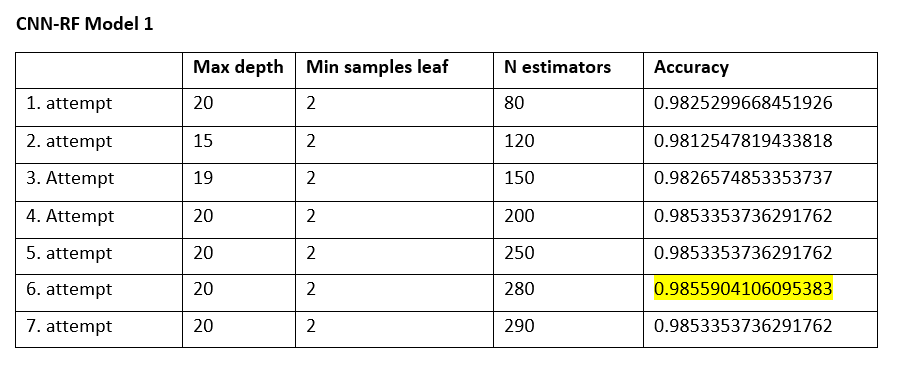

In [24]:
display(Image(filename="Images/CNN-RF1.png"))

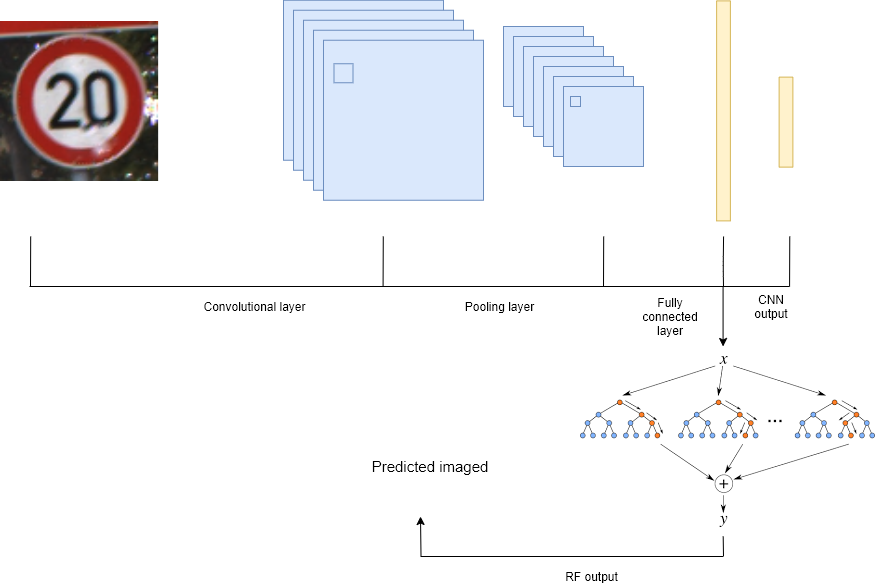

In [27]:
display(Image(filename="Images/RF-CNN.png"))

<font size=4 >The above figure is a representation of the CNN-RF model 1 structure. CNN-RF 1 model is not the best model in this study. Although, the model achieves a better result than its base CNN model output which is an expected outcome. </font>

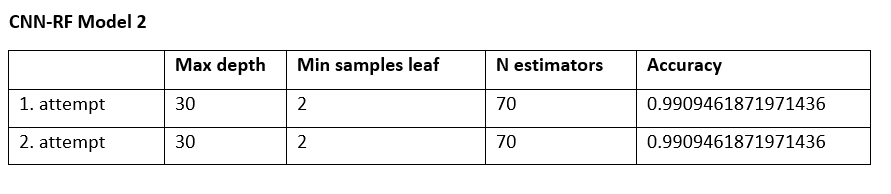

In [28]:
display(Image(filename="Images/CNN-RF21.png"))

<font size=4 > Here as it can be clearly seen unlike the CNN-RF model 1, this model is non-progressive under these conditions. However, it was achieved almost 0.05 better accuracy than the CNN-RF model 1. Although it was achieved a better result, the based CNN model namely CNN model 2 was achieved better test accuracy than CNN-RF model 2 which is a highly unexpected outcome.</font>

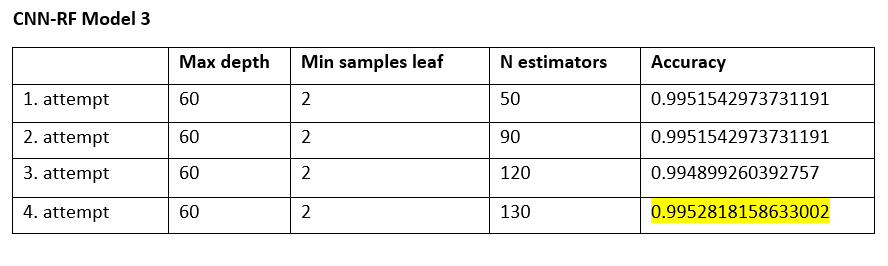

In [29]:
display(Image(filename="Images/CNN-RF31.png"))

<font size=4 >CNN-RF model 3 is the best hybrid model so far. However, the test accuracy is slightly lower than the pure CNN model test accuracy. This is also highly unexpected outcome.</font>

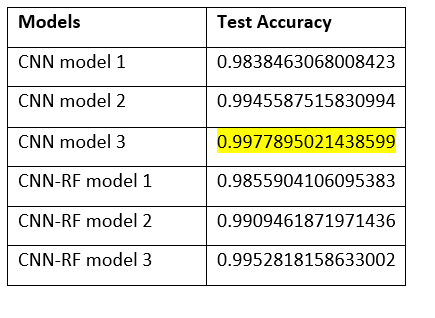

In [30]:
display(Image(filename="Images/Allmodels.png"))

<font size=4 >The best model is CNN mode 3 according to the test accuracies. Additionally, according to classification_report results, it is also the best model.  The test shows that accuracy, macro avg, and weighted avg are 1.0 which is a perfect result.</font>

# Best Model <a class="anchor" id="chapter5"></a>

<font size=4 >CNN model 3 is determined as the best model. The basic structure of the model as follows:</font>

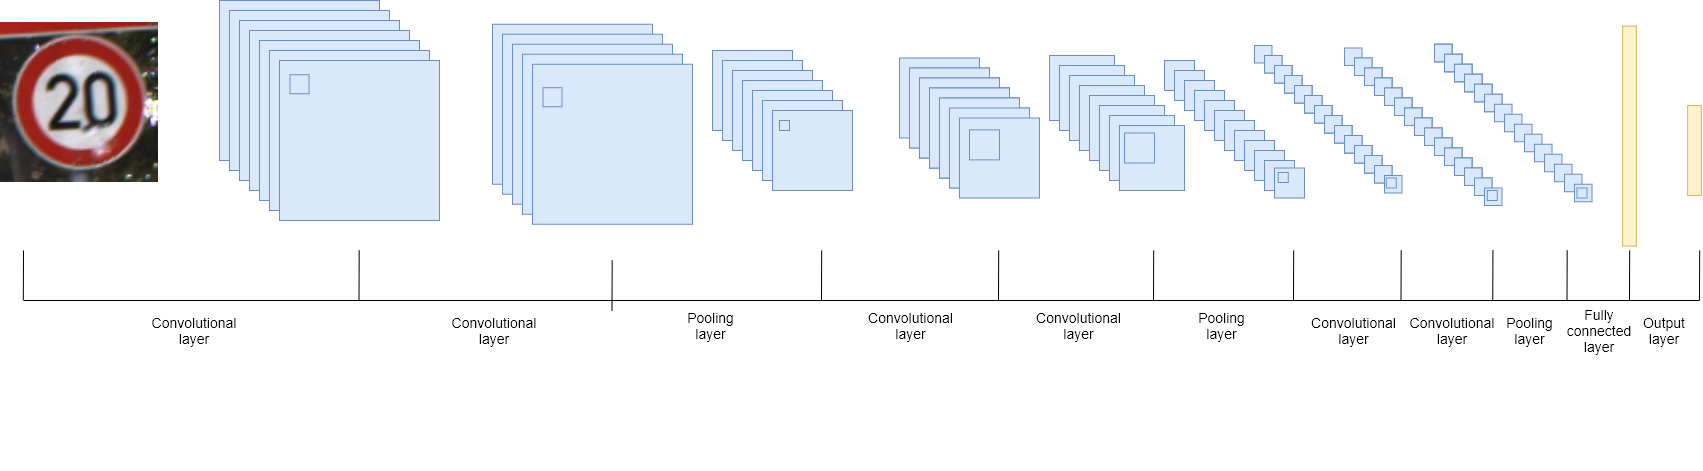

In [31]:
display(Image(filename="Images/bestcnnmodelimage1.png"))

<font size=4 >Now let's test the data with an image that it has never seen. The photos for testing between 00000 and 12629. The test is done by CNN-RF Model 1, CNN model 3 and CNN-RF Model 3. </font>

#### CNN-RF  Model 1

13 Yield right-of-way.


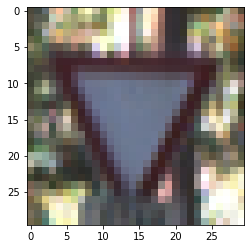

In [275]:
file_path = 'Test/00026.png'
def classifiercnnrf(file_path):
    image = Image.open(file_path)
    image = image.resize((30,30))
    plt.imshow(image)
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    outputofcnn = CNN_model2.predict(image)
    image_features=pd.DataFrame(data=outputofcnn)
    prediction2 = best_model_rf.predict(image_features)
    sign = classes[prediction2[0]]
    print(prediction2[0],sign)

classifiercnnrf(file_path)

#### CNN Model 3

16 No entry for motor vehicles more than 3,5 tons.


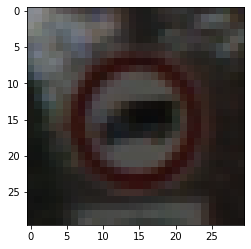

In [43]:
file_path = 'Test/00059.png'
def classifiercnn(file_path):
    image = Image.open(file_path)
    image = image.resize((30,30))
    plt.imshow(image)
    image = np.expand_dims(image, axis=0)
    image = np.array(image)
    prediction = model3.predict_classes([image])[0]
    sign = classes[prediction]
    print(prediction, sign)

classifiercnn(file_path)

#### CNN-RF Model 3

38 Pass on right only.


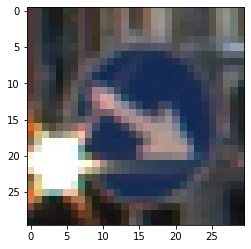

In [273]:
file_path = 'Test/00019.png'
def classifiercnnrf(file_path):
    image = Image.open(file_path)
    image = image.resize((30,30))
    plt.imshow(image)
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    outputofcnn = CNN_model3.predict(image)
    image_features=pd.DataFrame(data=outputofcnn)
    prediction2 = best_model_rf3.predict(image_features)
    sign = classes[prediction2[0]]
    print(prediction2[0],sign)

classifiercnnrf(file_path)

# Conclusion<a class="anchor" id="chapter6"></a>

<font size=4 >In conclusion, 3 different CNN architectures are built and these 3 models are combined with a random forest algorithm. The first model outcomes are improved by using random forest while the other 2 models' test accuracies are slightly decreased which is an unexpected situation. Moreover, the CNN-RF approach is tested with the MNIST dataset and the results are highly similar to the CNN-RF model 1. Combining CNN with random forest generally improves the result. However, CNN model 2 and CNN model 3 accuracies are more than 0.99. Random forest results may be affected by this situation. </font>

# References <a class="anchor" id="chapter7"></a>

1.) The data resource is Kaggle : [GTSRB - German Traffic Sign Recognition Benchmark ](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Train)

2.) Traffic sign names: [Resource 1](https://routetogermany.com/drivingingermany/road-signs )  and [resource 2](https://www.rhinocarhire.com/Drive-Smart-Blog/Drive-Smart-Germany/Germany-Road-Signs.aspx )

3.) [A Hybrid Cnn-Rf Method for Electron Microscopy Images Segmentation](https://www.omicsonline.org/open-access/a-hybrid-cnnrf-method-for-electron-microscopy-images-segmentation-1662-100X.1000114.pdf) 

4.) [Traffic Signs Detection for Real-World Application of an Advanced Driving Assisting System Using Deep Learning](https://link.springer.com/article/10.1007/s11063-019-10115-8 ) 
 
5.) [Convolutional neural networks: an overview and application in radiology](https://insightsimaging.springeropen.com/articles/10.1007/s13244-018-0639-9) 
 